In [1]:
import pandas as pd
import numpy as np
from flashcat.indices.eddi import calc_eddi, identify_flash_drought
print ('Successfully imported') 

Successfully imported


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import flashcat.indices.eddi as eddi_mod  # Import your new package

# ========================================================
# 1. SETUP & DATA LOADING (Matching your specific paths)
# ========================================================
pet_file = r'E:\POSTDOC\1_FD_indicator_comparison\InputData\gleam\daily\potential_evapotranspiration_gleam_day_1980_2022_world.txt'

print("Loading data from:", pet_file)

# Read the file (assuming space-separated: Year, Mon, Day, Grid1, Grid2...)
# We only read the first 8 columns (Dates + 5 Grids) to save memory/time
df_raw = pd.read_csv(pet_file, sep=r'\s+', header=None, usecols=range(8))

# Rename columns for clarity
grid_cols = [f'Grid_{i}' for i in range(1, 6)] # Grid_1 to Grid_5
df_raw.columns = ['Year', 'Month', 'Day'] + grid_cols

# Create a proper DatetimeIndex
df_raw['Date'] = pd.to_datetime(df_raw[['Year', 'Month', 'Day']])
df_raw = df_raw.set_index('Date')

# OPTIONAL: Handle Feb 29 (Your old code removed it)
# FlashCAT works with or without it, but to match your old results exactly, 
# we should follow your file's logic. If your text file INCLUDES Feb 29, 
# Pandas handles it naturally. 
# If you want to strictly remove Feb 29 to match the old array shape:
df_clean = df_raw[~((df_raw.index.month == 2) & (df_raw.index.day == 29))].copy()

print(f"Data Loaded. Shape: {df_clean.shape}")
print("First 5 rows:\n", df_clean.head())

# ========================================================
# 2. RUN FLASHCAT (The New Way)
# ========================================================
results = {}
events_list = []

# Loop through first 5 grids
for col in grid_cols:
    print(f"\nProcessing {col}...")
    
    # 1. Calculate EDDI (Returns Z-scores)
    # Note: FlashCAT uses a trailing window (standard). 
    # Your old code used 'uniform_filter1d' (centered). 
    # You might see a small time-shift (approx 7 days) in the peaks.
    pet_series = df_clean[col].values
    dates = df_clean.index
    
    eddi_z = eddi_mod.calc_eddi(pet_series, dates, window=14)
    
    # 2. Convert to Percentiles for Plotting (User Request)
    eddi_pct = norm.cdf(eddi_z) * 100
    results[col] = eddi_pct
    
    # 3. Identify Flash Drought Events
    # We pass the Z-score series to the identification function
    events_df = eddi_mod.identify_flash_drought(eddi_z, window=14)
    
    if not events_df.empty:
        events_df['Grid'] = col
        events_list.append(events_df)
        print(f"  -> Found {len(events_df)} flash drought events.")
    else:
        print("  -> No events found.")

# Combine all events
if events_list:
    all_events = pd.concat(events_list, ignore_index=True)
else:
    all_events = pd.DataFrame()

# ========================================================
# 3. PLOT RESULTS (Grid 1)
# ========================================================
target_grid = 'Grid_1'
print(f"\nplotting Time Series for {target_grid}...")

plt.figure(figsize=(15, 6))

# Extract data for Grid 1
dates = df_clean.index
pct_data = results[target_grid]

# Plot the EDDI Percentile
plt.plot(dates, pct_data, label='FlashCAT EDDI-14 (Percentile)', color='black', linewidth=0.8)

# Highlight Flash Droughts (Red shading)
grid1_events = all_events[all_events['Grid'] == target_grid]
for _, row in grid1_events.iterrows():
    plt.axvspan(row['onset_date'], row['end_date'], color='red', alpha=0.3, label='Identified Flash Drought' if _ == 0 else "")

# Add Threshold line (80th percentile)
plt.axhline(y=80, color='orange', linestyle='--', label='Drought Threshold (80th)')

plt.title(f'EDDI-14 Percentiles for {target_grid} (Verified with FlashCAT)', fontsize=14)
plt.ylabel('Percentile', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylim(0, 100)
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.show()

# ========================================================
# 4. PRINT IDENTIFIED EVENTS (For Comparison)
# ========================================================
print("\n=== Identified Flash Drought Events (First 5 Grids) ===")
if not all_events.empty:
    # Display columns matching your interest
    display_cols = ['Grid', 'onset_date', 'end_date', 'duration_days', 'max_intensity_pct']
    print(all_events[display_cols].to_string(index=False))
else:
    print("No events detected in the first 5 grids.")

Loading data from: E:\POSTDOC\1_FD_indicator_comparison\InputData\gleam\daily\potential_evapotranspiration_gleam_day_1980_2022_world.txt
Data Loaded. Shape: (15695, 8)
First 5 rows:
             Year  Month  Day  Grid_1    Grid_2  Grid_3  Grid_4    Grid_5
Date                                                                    
1980-01-01  1980      1    1     NaN -0.082895     NaN     NaN -0.029966
1980-01-02  1980      1    2     NaN -0.068091     NaN     NaN -0.032437
1980-01-03  1980      1    3     NaN  0.097845     NaN     NaN -0.024798
1980-01-04  1980      1    4     NaN  0.508457     NaN     NaN  0.052185
1980-01-05  1980      1    5     NaN  0.082700     NaN     NaN  0.131706



Processing Grid_1...
  -> Skipping Grid_1 (All values are NaN)

Processing Grid_2...
  -> Clamped 1922 negative values to 0.
  -> Found 34 flash drought events.

Processing Grid_3...
  -> Skipping Grid_3 (All values are NaN)

Processing Grid_4...
  -> Skipping Grid_4 (All values are NaN)

Processing Grid_5...
  -> Clamped 3018 negative values to 0.
  -> Found 28 flash drought events.

Plotting 2012 Time Series for Grid_2...


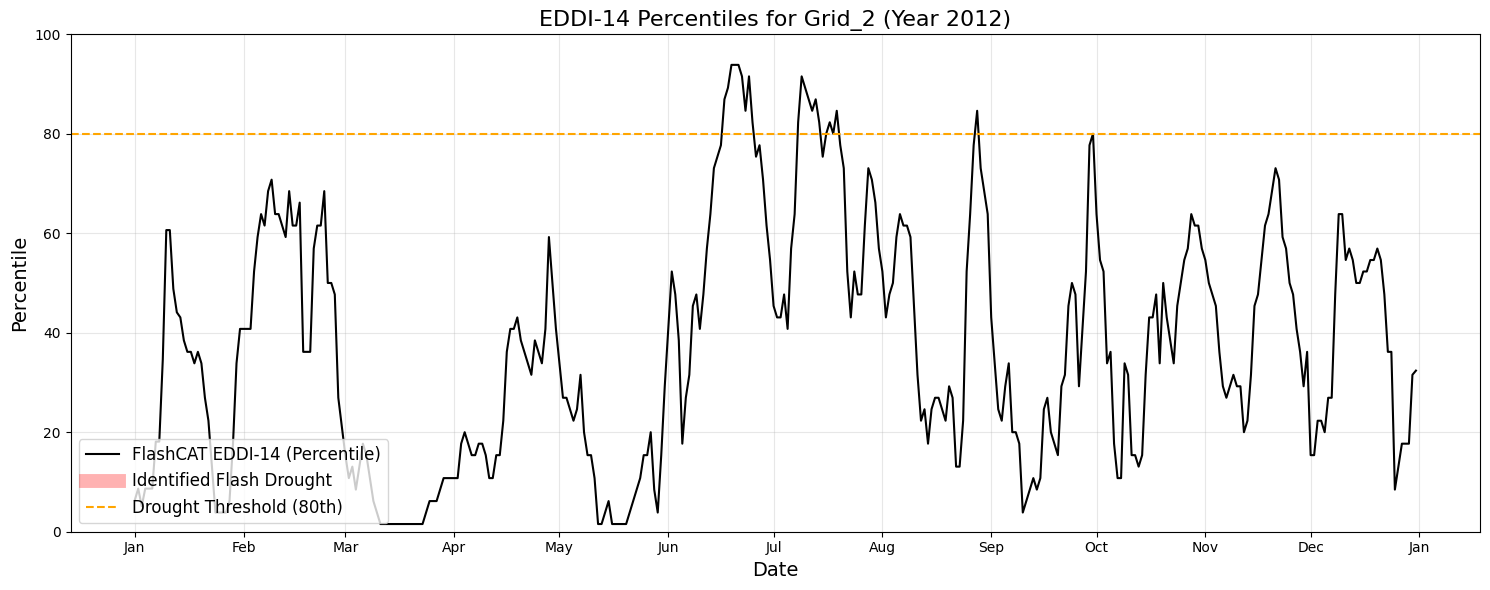


=== Identified Flash Drought Events (First 5 Grids) ===
  Grid onset_date   end_date  duration_days  max_intensity_pct
Grid_2 1980-10-11 1980-10-28             17          98.476806
Grid_2 1981-09-12 1981-10-04             22          98.476806
Grid_2 1983-06-03 1983-06-20             17          98.476806
Grid_2 1984-06-30 1984-07-23             23          98.476806
Grid_2 1985-11-19 1985-12-08             19          98.476806
Grid_2 1990-04-10 1990-04-30             20          98.476806
Grid_2 1991-07-05 1991-07-19             14          98.476806
Grid_2 1992-12-29 1993-01-18             20          98.440822
Grid_2 1993-04-11 1993-05-08             27          98.476806
Grid_2 1996-02-24 1996-03-20             25          96.168936
Grid_2 2000-09-14 2000-10-01             17          98.476806
Grid_2 2001-06-08 2001-07-03             25          98.476806
Grid_2 2005-07-08 2005-07-22             14          96.168936
Grid_2 2006-02-16 2006-03-02             14          98.47680

In [11]:
# ========================================================
# 2. RUN FLASHCAT (With Cleaning)
# ========================================================
results = {}
events_list = []

# Loop through first 5 grids
for col in grid_cols:
    print(f"\nProcessing {col}...")
    
    # FIX: Add .copy() so we can modify the array (clamp negative values)
    pet_series = df_clean[col].values.copy()
    
    # CHECK 1: Skip if Grid is all NaNs
    if np.isnan(pet_series).all():
        print(f"  -> Skipping {col} (All values are NaN)")
        results[col] = np.full(len(pet_series), np.nan)
        continue

    # CHECK 2: Clamp negative values to 0
    n_neg = np.sum(pet_series < 0)
    if n_neg > 0:
        print(f"  -> Clamped {n_neg} negative values to 0.")
        pet_series[pet_series < 0] = 0  # Now this will work!
    
    dates = df_clean.index
    
    # 1. Calculate EDDI
    eddi_z = eddi_mod.calc_eddi(pet_series, dates, window=14)
    
    # 2. Convert to Percentiles
    eddi_pct = norm.cdf(eddi_z) * 100
    results[col] = eddi_pct
    
    # 3. Identify Events
    events_df = eddi_mod.identify_flash_drought(eddi_z, window=14)
    
    if not events_df.empty:
        events_df['Grid'] = col
        events_list.append(events_df)
        print(f"  -> Found {len(events_df)} flash drought events.")
    else:
        print("  -> No events found.")

# Combine all events
if events_list:
    all_events = pd.concat(events_list, ignore_index=True)
else:
    all_events = pd.DataFrame()

# ========================================================
# 3. PLOT RESULTS (ZOOMED IN: YEAR 2012)
# ========================================================
# Find the first grid that actually had data
valid_grids = [k for k, v in results.items() if not np.isnan(v).all()]

if valid_grids:
    target_grid = valid_grids[0] # Usually Grid_1
    print(f"\nPlotting 2012 Time Series for {target_grid}...")

    # 1. Setup the 2012 Filter
    plot_year = 2012
    start_date = f'{plot_year}-01-01'
    end_date = f'{plot_year}-12-31'
    
    # Filter dates and data
    dates = df_clean.index
    mask_2012 = (dates >= start_date) & (dates <= end_date)
    
    dates_2012 = dates[mask_2012]
    pct_data_2012 = results[target_grid][mask_2012]

    plt.figure(figsize=(15, 6))

    # 2. Plot EDDI
    plt.plot(dates_2012, pct_data_2012, label='FlashCAT EDDI-14 (Percentile)', 
             color='black', linewidth=1.5) # Made line slightly thicker for visibility

    # 3. Highlight Flash Droughts (Only if they happen in 2012)
    if not all_events.empty:
        grid_events = all_events[all_events['Grid'] == target_grid]
        
        for _, row in grid_events.iterrows():
            # Check if the event overlaps with 2012
            event_start = row['onset_date']
            event_end = row['end_date']
            
            # Simple overlap check
            if (event_start.year == plot_year) or (event_end.year == plot_year):
                # Clamp the shading to the plot limits so it doesn't look weird
                shade_start = max(event_start, pd.Timestamp(start_date))
                shade_end = min(event_end, pd.Timestamp(end_date))
                
                plt.axvspan(shade_start, shade_end, color='red', alpha=0.3)

    # Add dummy legend entry for the red span
    plt.plot([], [], color='red', alpha=0.3, linewidth=10, label='Identified Flash Drought')

    # Threshold Line
    plt.axhline(y=80, color='orange', linestyle='--', label='Drought Threshold (80th)')

    # Formatting
    plt.title(f'EDDI-14 Percentiles for {target_grid} (Year {plot_year})', fontsize=16)
    plt.ylabel('Percentile', fontsize=14)
    plt.xlabel('Date', fontsize=14)
    plt.ylim(0, 100)
    plt.legend(loc='lower left', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Make x-axis dates look nice
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Show Month names
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo valid data found to plot.")

# ========================================================
# 4. PRINT IDENTIFIED EVENTS
# ========================================================
print("\n=== Identified Flash Drought Events (First 5 Grids) ===")
if not all_events.empty:
    display_cols = ['Grid', 'onset_date', 'end_date', 'duration_days', 'max_intensity_pct']
    print(all_events[display_cols].to_string(index=False))
else:
    print("No events detected.")


--- Comparing Old vs. New Results for Grid_2 in 2012 ---
Loading old file (Grid 2 only)...


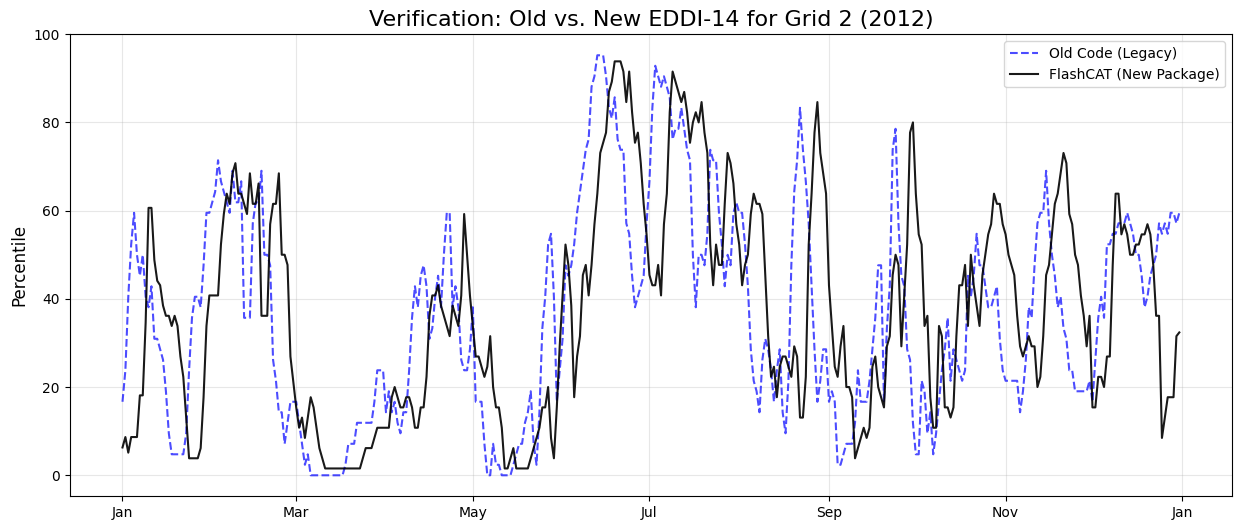

Comparison plot generated.


In [22]:
# ========================================================
# 5. VERIFICATION: COMPARE NEW VS. OLD (GRID 2, 2012)
# ========================================================
target_grid_idx = 2  # We want Grid 2
print(f"\n--- Comparing Old vs. New Results for Grid_{target_grid_idx} in 2012 ---")

old_file_path = r'E:\POSTDOC\1_FD_indicator_comparison\InputData\gleam\FD_identification\eddi14_percentile_timeseries.txt'

try:
    print("Loading old file (Grid 2 only)...")
    
    # OPTIMIZATION: Read ONLY Year(0), Month(1), Day(2) and Grid 2 (4)
    # Grid 1 is at index 3, so Grid 2 is at index 4.
    # df_old = pd.read_csv(
    #     old_file_path, 
    #     sep=r'\s+', 
    #     header=None,
    #     usecols=[0, 1, 2, 4],  # Grab dates + Grid 2
    #     names=['Year', 'Month', 'Day', 'Old_Data'] # Assign custom names immediately
    # )
    
    # Create Date Index
    df_old['Date'] = pd.to_datetime(df_old[['Year', 'Month', 'Day']])
    df_old = df_old.set_index('Date')
    
    # Filter for 2012
    old_series_2012 = df_old.loc['2012-01-01':'2012-12-31', 'Old_Data']
    
    # Get the NEW Result (FlashCAT) for Grid 2
    # Ensure you are grabbing the correct column from your calculated 'results'
    new_data_col = f'Grid_{target_grid_idx}'
    new_series_full = pd.Series(results[new_data_col], index=df_clean.index)
    new_series_2012 = new_series_full['2012-01-01':'2012-12-31']

    # Plot Comparison
    plt.figure(figsize=(15, 6))
    
    # Plot OLD (Blue Dashed)
    plt.plot(old_series_2012.index, old_series_2012.values, 
             label='Old Code (Legacy)', color='blue', linestyle='--', alpha=0.7)
    
    # Plot NEW (Black Solid)
    plt.plot(new_series_2012.index, new_series_2012.values, 
             label='FlashCAT (New Package)', color='black', linewidth=1.5, alpha=0.9)

    plt.title(f'Verification: Old vs. New EDDI-14 for Grid {target_grid_idx} (2012)', fontsize=16)
    plt.ylabel('Percentile', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format x-axis
    import matplotlib.dates as mdates
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    plt.show()

    print("Comparison plot generated.")

except Exception as e:
    print(f"ERROR: {e}")

In [19]:
df_old1 = pd.read_csv(
        old_file_path, 
        sep=r'\s+', 
        header=None,
        usecols=[0, 1, 2, 4],  # Grab dates + Grid 2
        names=['Year', 'Month', 'Day', 'Old_Data'] # Assign custom names immediately
    )
df_old1

,Year,Month,Day,Old_Data
0,1980,1,1,69.05
1,1980,1,2,66.67
2,1980,1,3,73.81
3,1980,1,4,69.05
4,1980,1,5,69.05
...,...,...,...,...
15690,2022,12,27,9.52
15691,2022,12,28,9.52
15692,2022,12,29,7.14
15693,2022,12,30,7.14


In [ ]:
import pandas as pd
import numpy as np
import flashcat.indices.rzsm as rzsm_mod

# 1. Generate Dummy Daily RZSM
dates = pd.date_range('2000-01-01', '2005-12-31')
rzsm = np.random.normal(0.3, 0.05, len(dates)) # Mean 0.3

# 2. Simulate Flash Drought (Rapid Dry Down)
# Year 2002, Day 150-180 (Pentads ~30-36)
# Start high (0.4) -> Drop fast to low (0.1)
fd_mask = (dates.year == 2002)
# Create a linear drop
start_day = 150
end_day = 180
rzsm[fd_mask & (dates.dayofyear >= start_day) & (dates.dayofyear <= end_day)] = np.linspace(0.45, 0.05, 31)
# Stay low for a bit
rzsm[fd_mask & (dates.dayofyear > end_day) & (dates.dayofyear <= end_day+20)] = 0.05

# 3. Calculate
print("Calculating Percentiles...")
df_pentad = rzsm_mod.calc_rzsm_percentiles(rzsm, dates)

# 4. Identify
print("Identifying Flash Droughts...")
events = rzsm_mod.identify_flash_drought(df_pentad)

print("\nDetected Events:")
print(events)